# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 2, #degree
        'n': 9, #number of variables
        'monomial_vars': None, #int or None
        'laurent': True, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0.05,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 50000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 50000,
                
        'interpretation_net_output_monomials': None, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': True,

        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 10,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex, clear_output



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [5]:
from utilities.utility_functions import flatten, rec_gen

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    print(list_of_monomial_identifiers_extended)        
else:
    variable_sets = [[_d for _d in range(d+1)] for _ in range(n)]  
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)

    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity: ' + str(sparsity))
    print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    if np.sum(monomial_identifier) <= d:
        if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
            list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 19683
[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 2], [0, 0, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0, 0, 2, 1], [0, 0, 0, 0, 0, 0, 0, 2, 2], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0, 2], [0, 0, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 1, 2], [0, 0, 0, 0, 0, 0, 1, 2, 0], [0, 0, 0, 0, 0, 0, 1, 2, 1], [0, 0, 0, 0, 0, 0, 1, 2, 2], [0, 0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 0, 2, 0, 1], [0, 0, 0, 0, 0, 0, 2, 0, 2], [0, 0, 0, 0, 0, 0, 2, 1, 0], [0, 0, 0, 0, 0, 0, 2, 1, 1], [0, 0, 0, 0, 0, 0, 2, 1, 2], [0, 0, 0, 0, 0, 0, 2, 2, 0], [0, 0, 0, 0, 0, 0, 2, 2, 1], [0, 0, 0, 0, 0, 0, 2, 2, 2], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1, 0, 0, 2], [0, 0, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, 1, 0, 1, 2], [0, 0, 0, 0, 0, 1, 0, 2

  0%|          | 0/19683 [00:00<?, ?it/s]

List length: 55
[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0, 1, 0], [0, 0, 0, 0, 1, 0, 1, 0, 0], [0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 1, 0, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 1, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0

In [6]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_55_drop0.25e500b256_custom/lnets_50000_275-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_9_d_2_laurent_negd_0_prob_0_spars_55_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_50000_275-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_9_d_2_laurent_negd_0_prob_0_spars_55_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [9]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [10]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed: 10.9min finished


## Data Inspection

In [11]:
lambda_net_dataset.as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
33553  1373158606            -0.278            -0.667            -0.234   
9427   1373158606            -0.131             0.830            -0.700   
199    1373158606             0.360            -0.884             0.858   
12447  1373158606             0.088            -0.031            -0.050   
39489  1373158606            -0.554            -0.054            -0.761   

       000000010-target  000000011-target  000000020-target  000000100-target  \
33553            -0.161            -0.706             0.321            -0.960   
9427             -0.436            -0.003            -0.641             0.294   
199              -0.555             0.999            -0.657             0.543   
12447             0.522             0.888             0.295            -0.280   
39489            -0.447            -0.387             0.157             0.654   

       000000101-target  000000110-target  000000200-target  000001000-target  \
33553            -0.786            -0.789            -0.921            -0.466   
9427              0.403             0.083             0.710             0.852   
199              -0.553            -0.838             0.750             0.718   
12447            -0.620            -0.300             0.503             0.331   
39489            -0.644            -0.461            -0.230             0.321   

       000001001-target  000001010-target  000001100-target  000002000-target  \
33553             0.352             0.617            -0.600             0.188   
9427              0.654             0.580             0.576            -0.798   
199              -0.193             0.405             0.114             0.706   
12447             0.966             0.092             0.814            -0.631   
39489            -0.420             0.849            -0.870             0.717   

       000010000-target  000010001-target  000010010-target  000010100-target  \
33553            -0.186             0.003             0.787             0.512   
9427              0.431            -0.042            -0.664             0.823   
199              -0.370             0.047            -0.029            -0.292   
12447            -0.748            -0.376             0.412             0.489   
39489            -0.535             0.101             0.045            -0.776   

       000011000-target  000020000-target  000100000-target  000100001-target  \
33553             0.125            -0.271            -0.022             0.009   
9427             -0.509             0.561             0.794             0.064   
199               0.783            -0.668            -0.701             0.154   
12447            -0.218             0.363            -0.265             0.302   
39489             0.610             0.906            -0.538             0.135   

       000100010-target  000100100-target  000101000-target  000110000-target  \
33553            -0.102             0.896            -0.015             0.586   
9427              0.117             0.333             0.161            -0.337   
199               0.315            -0.611            -0.219             0.893   
12447            -0.662             0.732             0.486            -0.797   
39489            -0.625            -0.707             0.256            -0.123   

       000200000-target  001000000-target  001000001-target  001000010-target  \
33553             0.246            -0.532             0.500             0.028   
9427             -0.032            -0.438             0.936             0.499   
199              -0.507             0.337             0.480            -0.104   
12447             0.512            -0.421             0.605            -0.775   
39489             0.346             0.688            -0.276             0.955   

       001000100-target  001001000-target  001010000-target  001100000-target  \
33553            -0.403             0.341             0.372             

In [12]:
lambda_net_dataset.as_pandas().describe()

seed  000000000-target  000000001-target  000000002-target  \
count      50000.000         50000.000         50000.000         50000.000   
mean  1373158606.000            -0.002             0.002             0.005   
std            0.000             0.577             0.577             0.578   
min   1373158606.000            -1.000            -1.000            -1.000   
25%   1373158606.000            -0.501            -0.497            -0.494   
50%   1373158606.000            -0.004             0.007             0.008   
75%   1373158606.000             0.497             0.500             0.507   
max   1373158606.000             1.000             1.000             1.000   

       000000010-target  000000011-target  000000020-target  000000100-target  \
count         50000.000         50000.000         50000.000         50000.000   
mean             -0.002            -0.001            -0.002             0.001   
std               0.576             0.577             0.579             0.578   
min              -1.000            -1.000            -1.000            -1.000   
25%              -0.498            -0.501            -0.505            -0.501   
50%              -0.005            -0.002            -0.000             0.000   
75%               0.496             0.500             0.502             0.504   
max               1.000             1.000             1.000             1.000   

       000000101-target  000000110-target  000000200-target  000001000-target  \
count         50000.000         50000.000         50000.000         50000.000   
mean              0.004             0.002            -0.002            -0.002   
std               0.577             0.577             0.576             0.577   
min              -1.000            -1.000            -1.000            -1.000   
25%              -0.497            -0.496            -0.501            -0.496   
50%               0.007             0.004            -0.005            -0.004   
75%               0.503             0.500             0.496             0.498   
max               1.000             1.000             1.000             1.000   

       000001001-target  000001010-target  000001100-target  000002000-target  \
count         50000.000         50000.000         50000.000         50000.000   
mean             -0.001            -0.002             0.002             0.001   
std               0.577             0.577             0.575             0.577   
min              -1.000            -1.000            -1.000            -1.000   
25%              -0.496            -0.500            -0.494            -0.499   
50%              -0.003            -0.003             0.000             0.002   
75%               0.500             0.497             0.499             0.498   
max               1.000             1.000             1.000             1.000   

       000010000-target  000010001-target  000010010-target  000010100-target  \
count         50000.000         50000.000         50000.000         50000.000   
mean             -0.003            -0.005            -0.003            -0.003   
std               0.579             0.577             0.576             0.578   
min              -1.000            -1.000            -1.000            -1.000   
25%              -0.501            -0.508            -0.503            -0.507   
50%              -0.006            -0.007            -0.003            -0.009   
75%               0.499             0.497             0.494             0.498   
max               1.000             1.000             1.000             1.000   

       000011000-target  000020000-target  000100000-target  000100001-target  \
count         50000.000         50000.000         50000.000         50000.000   
mean              0.003            -0.003            -0.002            -0.001   
std               0.577             0.579             0.577             0.577   
min              -1.000            -1.000            -1.000          

In [13]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.73082941, 0.05213017, 0.66572068, 0.87712713, 0.06067624,
        0.09081775, 0.72254459, 0.20717409, 0.4915632 ],
       [0.624057  , 0.90447014, 0.92468088, 0.93750586, 0.65198702,
        0.44290109, 0.35719106, 0.71362528, 0.38521999],
       [0.20728853, 0.3990572 , 0.23764756, 0.50852175, 0.94043697,
        0.8591    , 0.34855253, 0.87088499, 0.99980287],
       [0.58654567, 0.8845656 , 0.90932963, 0.90834534, 0.62394553,
        0.8081525 , 0.91104895, 0.75970973, 0.96291015],
       [0.8217497 , 0.33359407, 0.6376189 , 0.62417853, 0.67121809,
        0.66421107, 0.52845012, 0.51743737, 0.97099857],
       [0.60145068, 0.17803421, 0.38437711, 0.67995954, 0.98294559,
        0.52212317, 0.62965456, 0.13924224, 0.75433468],
       [0.7222318 , 0.81118147, 0.21146383, 0.56395218, 0.82417586,
        0.83460542, 0.3015649 , 0.88933477, 0.25549277],
       [0.73541227, 0.09589284, 0.53089947, 0.84096981, 0.90104095,
        0.86411768, 0.26617861, 0.48882316, 0.82097931],


In [14]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[-1.24438706],
       [ 0.54973534],
       [-0.43056807],
       [-0.87518897],
       [ 0.02303034],
       [-0.46104388],
       [ 1.43354167],
       [ 0.94475261],
       [ 0.74023684],
       [-0.85012547]])

## Generate Datasets for Interpretation-Net training

In [15]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        
        if isinstance(test_size, float):
            test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))
        
        test_seeds = random.sample(complete_seed_list, test_size)
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [16]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(44910, 3192)

In [17]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(4990, 3192)

In [18]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 3192)

In [19]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
9901   1373158606            -0.573             0.604             0.985   
5910   1373158606            -0.561             0.918            -0.312   
18619  1373158606            -0.658            -0.156            -0.220   
33312  1373158606             0.412            -0.144             0.449   
47430  1373158606             0.820            -0.435            -0.994   

       000000010-target  000000011-target  000000020-target  000000100-target  \
9901             -0.216            -0.916            -0.688             0.468   
5910             -0.810            -0.739            -0.656            -0.602   
18619            -0.442            -0.128             0.868             0.122   
33312            -0.213            -0.165            -0.150            -0.956   
47430            -0.924             0.210             0.784            -0.226   

       000000101-target  000000110-target  000000200-target  000001000-target  \
9901             -0.830            -0.195             0.685            -0.408   
5910              0.530            -0.159            -0.701            -0.951   
18619             0.239             0.532            -0.855             0.927   
33312             0.129             0.392            -0.267             0.249   
47430             0.960            -0.471            -0.784            -0.891   

       000001001-target  000001010-target  000001100-target  000002000-target  \
9901             -0.711             0.991            -0.992             0.055   
5910             -0.408             0.338             0.278            -0.345   
18619             0.703            -0.352            -0.708             0.238   
33312             0.738            -0.136             0.236            -0.744   
47430            -0.659             0.370            -0.959             0.486   

       000010000-target  000010001-target  000010010-target  000010100-target  \
9901             -0.992            -0.708            -0.871            -0.824   
5910              0.095             0.023            -0.117            -0.089   
18619            -0.710             0.104             0.470             0.487   
33312            -0.316             0.151             0.584             0.591   
47430             0.360             0.117             0.422            -0.609   

       000011000-target  000020000-target  000100000-target  000100001-target  \
9901              0.370             0.952             0.883            -0.211   
5910             -0.716             0.764             0.166            -0.514   
18619             0.840            -0.069            -0.289             0.082   
33312             0.869             0.682            -0.088             0.917   
47430            -0.864             0.218             0.888             0.803   

       000100010-target  000100100-target  000101000-target  000110000-target  \
9901             -0.253            -0.858             0.085            -0.438   
5910             -0.159            -0.761             0.644            -0.116   
18619             0.479             0.297             0.783             0.696   
33312            -0.812             0.583             0.650             0.482   
47430             0.368            -0.154            -0.579            -0.672   

       000200000-target  001000000-target  001000001-target  001000010-target  \
9901             -0.503             0.609            -0.999             0.415   
5910             -0.278             0.384             0.237            -0.468   
18619             0.725             0.665            -0.338            -0.591   
33312            -0.223             0.832            -0.928            -0.978   
47430             0.619            -0.157             0.808            -0.483   

       001000100-target  001001000-target  001010000-target  001100000-target  \
9901              0.006            -0.688             0.996             

In [20]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
7038   1373158606             0.069            -0.690            -0.646   
30770  1373158606             0.516             0.868            -0.809   
41342  1373158606            -0.169            -0.950             0.017   
21084  1373158606             0.686             0.648             0.772   
47211  1373158606            -0.727            -0.209             0.996   

       000000010-target  000000011-target  000000020-target  000000100-target  \
7038              0.219             0.824            -0.861            -0.269   
30770            -0.565            -0.666            -0.275            -0.222   
41342             0.277             0.562            -0.264             0.711   
21084             0.709             0.027             0.563             0.615   
47211            -0.182             0.706            -0.478            -0.207   

       000000101-target  000000110-target  000000200-target  000001000-target  \
7038              0.974             0.069            -0.025            -0.065   
30770             0.847            -0.017            -0.096             0.034   
41342            -0.453            -0.990             0.420             0.416   
21084            -0.781             0.147             0.295             0.027   
47211            -0.971            -0.411             0.153             0.989   

       000001001-target  000001010-target  000001100-target  000002000-target  \
7038             -0.923             0.476             0.777             0.383   
30770             0.706            -0.349            -0.637            -0.453   
41342             0.763             0.440             0.440             0.205   
21084            -0.042             0.966            -0.034            -0.206   
47211             0.323            -0.614             0.158            -0.488   

       000010000-target  000010001-target  000010010-target  000010100-target  \
7038             -0.670             0.566             0.175             0.953   
30770            -0.680            -0.729             0.307            -0.790   
41342             0.889            -0.765             0.041            -0.831   
21084            -0.617             0.280             0.128            -0.153   
47211             0.571             0.444             0.360            -0.808   

       000011000-target  000020000-target  000100000-target  000100001-target  \
7038              0.682            -0.897             0.612             0.910   
30770            -0.270             0.098            -0.706            -0.586   
41342             0.291             0.773            -0.838            -0.178   
21084            -0.663            -0.889             0.395            -0.354   
47211             0.296             0.224            -0.807             0.158   

       000100010-target  000100100-target  000101000-target  000110000-target  \
7038              0.262             0.656             0.510            -0.091   
30770            -0.116            -0.164            -0.886            -0.332   
41342            -0.362            -0.262             0.176             0.110   
21084             0.770             0.216            -0.417            -0.199   
47211             0.966             0.982             0.009            -0.675   

       000200000-target  001000000-target  001000001-target  001000010-target  \
7038             -0.585             0.412             0.425            -0.937   
30770             0.383            -0.618             0.293            -0.935   
41342            -0.812             0.365             0.765            -0.197   
21084            -0.659            -0.672             0.791            -0.688   
47211            -0.976             0.102            -0.638             0.836   

       001000100-target  001001000-target  001010000-target  001100000-target  \
7038             -0.475            -0.050            -0.952            -

In [21]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
35587  1373158606            -0.504            -0.292             0.595   
32681  1373158606            -0.152             0.146             0.135   
40971  1373158606             0.130             0.854            -0.511   
21022  1373158606            -0.454             0.004             0.378   
6403   1373158606             0.532             0.794            -0.808   

       000000010-target  000000011-target  000000020-target  000000100-target  \
35587            -0.354            -0.615             0.236            -0.489   
32681            -0.284             0.913             0.750             0.365   
40971             0.702            -0.262            -0.207             0.213   
21022            -0.284             0.541             0.492             0.568   
6403             -0.471            -0.281             0.428             0.260   

       000000101-target  000000110-target  000000200-target  000001000-target  \
35587            -0.443            -0.373             0.040            -0.455   
32681            -0.678            -0.271             0.064             0.579   
40971            -0.955            -0.358             0.576             0.086   
21022            -0.288            -0.540             0.313            -0.528   
6403              0.729             0.748             0.407             0.895   

       000001001-target  000001010-target  000001100-target  000002000-target  \
35587            -0.676             0.048            -0.455             0.891   
32681            -0.035             0.701            -0.129            -0.309   
40971            -0.295            -0.490            -0.395            -0.322   
21022             0.877             0.115             0.107             0.776   
6403             -0.392            -0.279            -0.716             0.575   

       000010000-target  000010001-target  000010010-target  000010100-target  \
35587             0.812            -0.986            -0.613            -0.024   
32681             0.102             0.371             0.165            -0.347   
40971            -0.136             0.119            -0.220             0.341   
21022            -0.289            -0.044             0.933            -0.870   
6403              0.189            -0.598             0.756            -0.819   

       000011000-target  000020000-target  000100000-target  000100001-target  \
35587            -0.980            -0.547            -0.009            -0.945   
32681            -0.775            -0.557             0.562             0.613   
40971             0.882             0.322             0.406            -0.663   
21022            -0.121             0.308             0.557            -0.658   
6403             -0.029             0.102            -0.199            -0.801   

       000100010-target  000100100-target  000101000-target  000110000-target  \
35587             0.772             0.353            -0.211             0.632   
32681             0.896            -0.199             0.735             0.564   
40971             0.136            -0.180             0.128            -0.792   
21022            -0.873            -0.998             0.731             0.783   
6403              0.382            -0.551             0.488             0.983   

       000200000-target  001000000-target  001000001-target  001000010-target  \
35587            -0.792            -0.966            -0.573             0.721   
32681            -0.223             0.133             0.137             0.711   
40971            -0.683             0.782             0.773            -0.284   
21022            -0.059            -0.675             0.725            -0.461   
6403             -0.088             0.714            -0.333             0.281   

       001000100-target  001001000-target  001010000-target  001100000-target  \
35587            -0.650            -0.517             0.912            -

## Interpretation Network Training

In [22]:
#%load_ext autoreload

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   10.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   15.4s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   23.4s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   34.9s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   49.9s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 6030 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done 7180 tasks      | elapsed:  4.0min
[Parallel(n_jobs=10)]: Done 8430 tasks      | elapsed:  4.7min
[Parallel(n_jobs=10)]: Done 9780 tasks      | elapsed:  5.4min
[Parallel(n_jobs=10)]: Done 11230 tasks      

Training Time: 3:08:33
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:23
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>
'symbolic_regression_functions'
EXIT symbolic_regression_functions
<class 'KeyError'>
FV Calculation Time: 0:37:23
-----------------

Traceback (most recent call last):
  File "../utilities/InterpretationNet.py", line 1076, in calculate_all_function_values
    function_values = parallel_fv_calculation_from_sympy(polynomial_dict['symbolic_regression_functions'], lambda_net_dataset.X_test_data_list, n_jobs_parallel_fv=n_jobs_parallel_fv, backend=backend)
KeyError: 'symbolic_regression_functions'


lambda_preds_VS_lstsq_target_polynomials
[[-1.5244007  -2.2048886  -1.3979107  ... -1.1768485  -0.69404644
  -0.62178797]
 [-0.05562051  0.53444177  0.81078315 ...  0.6990088   1.6633943
   1.0104213 ]
 [ 1.6981022   1.6969646   1.7508861  ...  0.5995603   0.9110105
   0.47739223]
 ...
 [ 0.25445992 -0.9484305   2.0521278  ... -0.80888444 -0.54142106
   0.3124017 ]
 [-0.73330796  2.9190004   3.5741777  ...  0.8975416   2.5645938
  -0.48203936]
 [ 3.7609951   2.2268589   3.9370363  ...  1.4201777   3.2200158
   2.8819132 ]]
[[-1.5445607  -2.2192614  -1.3902525  ... -1.1654903  -0.6934945
  -0.6037695 ]
 [-0.09620155  0.5077658   0.8054701  ...  0.70438397  1.6462445
   1.016158  ]
 [ 1.658606    1.7170014   1.7596227  ...  0.58340204  0.8907642
   0.4829692 ]
 ...
 [ 0.27146763 -0.9380261   2.0124743  ... -0.8070888  -0.55720353
   0.3213292 ]
 [-0.77977425  2.7679179   3.6783364  ...  0.93199825  2.585765
  -0.5650493 ]
 [ 3.7619722   2.2029152   3.919105   ...  1.4181743   3.1787786
 

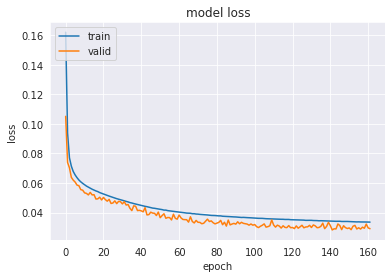

In [23]:
#%autoreload 2
(history_list, 

#scores_valid_list,
scores_test_list, 

#function_values_valid_list, 
function_values_test_list, 

#polynomial_dict_valid_list,
polynomial_dict_test_list,

#distrib_dict_valid_list,
distrib_dict_test_list,

model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

## Evaluate Interpretation Net

In [24]:
function = sympify('2.9673590504451*b + d+ c - 0.213')
function_vars = function.atoms(Symbol)

In [25]:
function

2.9673590504451*b + c + d - 0.213

In [26]:
tuple(function_vars)

(d, c, b)

In [27]:
import sympy


In [28]:
lambda_function = lambdify([(abc.a, abc.b, abc.c, abc.d)], function, modules=["scipy", "numpy"])

In [29]:
lambda_function

<function _lambdifygenerated(_Dummy_22)>

In [30]:
data = [[1,2,3,4], [1,2,3,4]]

In [31]:
function_values = [lambda_function(data_point) for data_point in data]
function_values

[12.721718100890202, 12.721718100890202]

In [32]:
lambda_function = lambdify([function_vars], function, modules=["scipy", "numpy"])

In [33]:
lambda_function

<function _lambdifygenerated(_Dummy_23)>

In [34]:
data = [[2,3,4], [2,3,4]]

In [35]:
function_values = [lambda_function(data_point) for data_point in data]
function_values

[16.6564362017804, 16.6564362017804]

In [36]:
polynomial_dict_test_list[-1].keys()

dict_keys(['lstsq_lambda_pred_polynomials', 'lstsq_target_polynomials', 'target_polynomials', 'inet_polynomials'])

In [37]:
print('hi')

hi


In [38]:
poly_optimize = tf.constant([float(i) for i in range(interpretation_net_output_shape)])

if interpretation_net_output_monomials != None:
    poly_optimize_coeffs = poly_optimize[:interpretation_net_output_monomials]

    poly_optimize_identifiers_list = []
    for i in range(interpretation_net_output_monomials):
        poly_optimize_identifiers = tf.math.softmax(poly_optimize[sparsity*i+interpretation_net_output_monomials:sparsity*(i+1)+interpretation_net_output_monomials])
        poly_optimize_identifiers_list.append(poly_optimize_identifiers)
    poly_optimize_identifiers_list = tf.keras.backend.flatten(poly_optimize_identifiers_list)
    poly_optimize = tf.concat([poly_optimize_coeffs, poly_optimize_identifiers_list], axis=0)


In [39]:
poly_optimize

<tf.Tensor: shape=(55,), dtype=float32, numpy=
array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54.], dtype=float32)>

In [40]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [41]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3026)]            0         
_________________________________________________________________
hidden1_512 (Dense)          (None, 512)               1549824   
_________________________________________________________________
dropout1_0.25 (Dropout)      (None, 512)               0         
_________________________________________________________________
hidden2_1024 (Dense)         (None, 1024)              525312    
_________________________________________________________________
output_1024 (Dense)          (None, 55)                56375     
Total params: 2,131,511
Trainable params: 2,131,511
Non-trainable params: 0
_________________________________________________________________
None
{'name': 'model', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 3026), 'dtype':

In [42]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [43]:
scores_test_list[-1]

MAE  RMSE  MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN   NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN   NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN   NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN   NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.054 0.075 0.432   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.254 0.321 1.553   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.054 0.075 0.454   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.229 0.290 1.524   
lstsq_target_polynomials_VS_inet_polynomials       0.254 0.321 1.553   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.539   
target_polynomials_VS_lstsq_target_polynomials         1.000   
target_polynomials_VS_inet_polynomials                 0.120   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.539   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.139   
lstsq_target_polynomials_VS_inet_polynomials           0.120   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.000   
target_polynomials_VS_lstsq_target_polynomials                    1.000   
target_polynomials_VS_inet_polynomials                            0.000   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials                 0.000   
lstsq_target_polynomials_VS_inet_polynomials                      0.000   

                                                    MAE FV  RMSE FV  MAPE FV  \
lambda_preds_VS_target_polynomials                   0.031    0.043    0.144   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.028    0.037    0.139   
lambda_preds_VS_lstsq_target_polynomials             0.031    0.043    0.144   
lambda_preds_VS_inet_polynomials                     0.183    0.219    0.845   
target_polynomials_VS_lstsq_lambda_pred_polynom...   0.022    0.029    0.107   
target_polynomials_VS_lstsq_target_polynomials       0.000    0.000    0.000   
target_polynomials_VS_inet_polynomials               0.185    0.224    0.990   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...   0.022    0.029    0.122   
lstsq_lambda_pred_polynomials_VS_inet_polynomials    0.181    0.217    1.006   
lstsq_target_polynomials_VS_inet_polynomials         0.185    0.224    0.990   

                                                    R2 FV  RAAE FV  RMAE FV  \
lambda_preds_VS_target_polynomials                  0.998    0.033    0.251   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.999    0.029    0.196   
lambda_preds_VS_lstsq_target_polynomials            0.998    0.033    0.251   
lambda_preds_VS_inet_polynomials                    0.939    0.192    0.555   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.999    0.023    0.107   
target_polynomials_VS_lstsq_target_polynomials      1.000    0.000    0.000   
target_polynomials_VS_inet_polynomials              0.938    0.193    0.640   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.999    0.023    0.106   
lstsq_lambda_pred_polynomials_VS_inet_polynomials   0.940    0.190    0.607   
lstsq_target_polynomials_VS_inet_polynomials        0.938 

In [44]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.032 0.027 0.025 0.028   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.029 0.026 0.022 0.025   
lambda_preds_VS_lstsq_target_polynomials           0.032 0.027 0.025 0.028   
lambda_preds_VS_inet_polynomials                   0.137 0.216 0.123 0.141   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.024 0.021 0.017 0.018   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.148 0.213 0.126 0.141   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.024 0.021 0.017 0.018   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.136 0.215 0.121 0.139   
lstsq_target_polynomials_VS_inet_polynomials       0.148 0.213 0.126 0.141   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.031 0.030 0.038 0.029   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.024 0.026 0.034 0.026   
lambda_preds_VS_lstsq_target_polynomials           0.031 0.030 0.038 0.029   
lambda_preds_VS_inet_polynomials                   0.152 0.219 0.135 0.155   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.022 0.023 0.027 0.019   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.150 0.222 0.142 0.148   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.022 0.023 0.027 0.019   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.152 0.221 0.130 0.151   
lstsq_target_polynomials_VS_inet_polynomials       0.150 0.222 0.142 0.148   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.029 0.029 0.029 0.030   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.026 0.027 0.026 0.028   
lambda_preds_VS_lstsq_target_polynomials           0.029 0.029 0.029 0.030   
lambda_preds_VS_inet_polynomials                   0.094 0.365 0.143 0.141   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.018 0.017 0.021 0.017   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.091 0.375 0.148 0.144   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.018 0.017 0.021 0.017   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.088 0.366 0.140 0.138   
lstsq_target_polynomials_VS_inet_polynomials       0.091 0.375 0.148 0.144   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.029 0.032 0.033 0.036   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.026 0.029 0.030 0.035   
lambda_preds_VS_lstsq_target_polynomials           0.029 0.032 0.033 0.036   
lambda_preds_VS_inet_polynomials                   0.103 0.143 0.174 0.131   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.018 0.021 0.024 0.025   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.107 0.151 0.173 0.136   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.018 0.021 0.024 0.025   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.102 0.140 0.170 0.125   
lstsq_target_polynomials_VS_inet_polynomials       0.107 0.151 0.173 0.136   

                                                    L-16  L-17  L-18  L-19  \
lambda_preds_VS_target_polynomials                 0.028 0.032 0.038 0.041   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.025 0.031 0.034 0.039   
lambda_preds_VS_lstsq_target_polynomials           0.028 0.032 0.038 0.041   
lambda_preds_VS_inet_polynomials                   0.376 0.131 0.129 0.151   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.022 0.022 0.029 0.026   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.367 0.127 0.126 0.

In [45]:
distrib_dict_test_list[-1]['R2']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.997 0.999 0.998 0.997   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.998 0.999 0.998 0.998   
lambda_preds_VS_lstsq_target_polynomials           0.997 0.999 0.998 0.997   
lambda_preds_VS_inet_polynomials                   0.959 0.951 0.952 0.941   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 0.999 0.999 0.999   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.953 0.954 0.949 0.940   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.999 0.999 0.999 0.999   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.959 0.952 0.953 0.941   
lstsq_target_polynomials_VS_inet_polynomials       0.953 0.954 0.949 0.940   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.997 0.996 0.998 0.998   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.998 0.997 0.999 0.999   
lambda_preds_VS_lstsq_target_polynomials           0.997 0.996 0.998 0.998   
lambda_preds_VS_inet_polynomials                   0.938 0.855 0.983 0.951   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 0.998 0.999 0.999   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.938 0.854 0.981 0.955   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.999 0.998 0.999 0.999   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.938 0.855 0.984 0.953   
lstsq_target_polynomials_VS_inet_polynomials       0.938 0.854 0.981 0.955   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.997 0.998 0.998 0.998   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.998 0.999 0.998 0.999   
lambda_preds_VS_lstsq_target_polynomials           0.997 0.998 0.998 0.998   
lambda_preds_VS_inet_polynomials                   0.975 0.814 0.950 0.972   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 0.999 0.999 1.000   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.976 0.805 0.948 0.969   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.999 0.999 0.999 1.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.977 0.813 0.953 0.972   
lstsq_target_polynomials_VS_inet_polynomials       0.976 0.805 0.948 0.969   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.998 0.998 0.997 0.998   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.998 0.998 0.998 0.999   
lambda_preds_VS_lstsq_target_polynomials           0.998 0.998 0.997 0.998   
lambda_preds_VS_inet_polynomials                   0.976 0.966 0.943 0.983   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 0.999 0.999 0.999   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.974 0.962 0.940 0.982   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.999 0.999 0.999 0.999   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.976 0.967 0.943 0.984   
lstsq_target_polynomials_VS_inet_polynomials       0.974 0.962 0.940 0.982   

                                                    L-16  L-17  L-18  L-19  \
lambda_preds_VS_target_polynomials                 0.999 0.998 0.997 0.998   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.999 0.998 0.998 0.999   
lambda_preds_VS_lstsq_target_polynomials           0.999 0.998 0.997 0.998   
lambda_preds_VS_inet_polynomials                   0.866 0.975 0.969 0.980   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 0.999 0.998 0.999   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.874 0.976 0.970 0.

In [46]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
polynomial_inet = polynomial_dict_test_list[-1]['inet_polynomials'][index_min]

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

0.8523995455018784


-0.221851781010628*a**2 + 0.210494354367256*a*b + 0.160800814628601*a*c - 0.0480633303523064*a*d + 0.526574611663818*a*e + 0.0504435785114765*a*f + 0.216421410441399*a*g - 0.338344305753708*a*h - 0.0601314529776573*a*i + 0.166814655065536*a + 0.178620651364326*b**2 + 0.326646566390991*b*c - 0.0043923226185143*b*d + 0.749646723270416*b*e - 0.197929620742798*b*f - 0.410127907991409*b*g + 0.363072603940964*b*h - 0.505085349082947*b*i + 0.0918703526258469*b + 0.183609217405319*c**2 + 0.115410037338734*c*d - 0.416152685880661*c*e - 0.480415284633636*c*f + 0.0840853229165077*c*g - 0.094874769449234*c*h + 0.268369346857071*c*i + 0.096559651196003*c - 0.101810544729233*d**2 - 0.0720781087875366*d*e - 0.225350484251976*d*f - 0.419031292200089*d*g - 0.0033605785574764*d*h + 0.346429854631424*d*i - 0.205470010638237*d + 0.500272929668427*e**2 - 0.118374414741993*e*f + 0.205845698714256*e*g - 0.364385098218918*e*h + 0.226792514324188*e*i - 0.0295961890369654*e + 0.360821455717087*f**2 - 0.24996039

In [47]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_test_list[-1]['R2'].loc['lstsq_lambda_pred_polynomials_VS_inet_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.8621508257741537


-0.470601572548616*a**2 + 0.515813013856249*a*b + 0.114592069471876*a*c + 0.000350739783004*a*d + 0.730558406119012*a*e + 0.0157911635195492*a*f + 0.572392749262788*a*g - 0.739314312738634*a*h - 0.197362501145204*a*i + 0.26982764116842*a + 0.0401120005524635*b**2 + 0.193677435292959*b*c + 0.500371618763536*b*d + 0.891616820191901*b*e - 0.588246724493249*b*f - 0.785391968731559*b*g + 0.26057724209969*b*h - 0.783619925880907*b*i + 0.452094943118616*b + 0.200081432244*c**2 + 0.358209180182443*c*d - 0.478981829061371*c*e - 0.822712173070061*c*f - 0.0944344883429718*c*g - 0.076599217279399*c*h + 0.248822843463362*c*i + 0.243457114813483*c + 0.297591778206807*d**2 + 0.150847188562107*d*e - 0.55934550455501*d*f - 0.787096466559582*d*g - 0.299611638363228*d*h + 0.351316209802697*d*i - 0.669229676915085*d + 0.368262027884799*e**2 - 0.868283740309919*e*f - 0.0486166704443465*e*g - 0.882452821476334*e*h + 0.0732007061232399*e*i + 0.712849754408988*e + 0.998414237967642*f**2 - 0.0195971042717106*f

In [48]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.690884666258628*a**2 + 0.481045807122298*a*b + 0.0603413456322867*a*c - 0.0668784234286046*a*d + 0.80041001819982*a*e - 0.0620831079616257*a*f + 0.607154375232164*a*g - 0.817884617440731*a*h - 0.290981574151222*a*i + 0.635144935896927*a + 0.0532642462497547*b**2 + 0.183049057401728*b*c + 0.567018198536179*b*d + 0.995357183816774*b*e - 0.641308272988418*b*f - 0.893381280114449*b*g + 0.295308255458189*b*h - 0.836774654987342*b*i + 0.490297858371172*b + 0.151856098279387*c**2 + 0.366263783641792*c*d - 0.494746349797*c*e - 0.972133851308402*c*f - 0.0878038063081685*c*g - 0.118558998372128*c*h + 0.235901173381349*c*i + 0.415366980988822*c + 0.419738852705157*d**2 + 0.237241776760159*d*e - 0.602481491264067*d*f - 0.897522444056986*d*g - 0.262785494392014*d*h + 0.436366067821566*d*i - 0.848879188790164*d + 0.500372228494231*e**2 - 0.87915410187155*e*f - 0.0247752734043467*e*g - 0.797462960948178*e*h + 0.099746076744692*e*i + 0.418536065302139*e + 0.977941811328087*f**2 - 0.104450091091326*

In [49]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
polynomial_inet = polynomial_dict_test_list[-1]['inet_polynomials'][index_max]

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.9742291973040567


0.683051943778992*a**2 + 0.367709100246429*a*b + 0.458608031272888*a*c + 0.874663352966309*a*d - 0.0453781262040138*a*e - 0.567221999168396*a*f + 0.660634517669678*a*g - 0.204022094607353*a*h + 0.340939342975616*a*i + 1.17633497714996*a - 8.0340112617705e-5*b**2 + 0.231447711586952*b*c - 0.754648685455322*b*d + 0.555615365505219*b*e - 0.45827704668045*b*f + 0.217294529080391*b*g + 0.893348872661591*b*h - 0.653850436210632*b*i - 0.418327748775482*b + 0.318215012550354*c**2 - 0.602509260177612*c*d + 0.166436195373535*c*e + 0.968466877937317*c*f + 0.0594927184283733*c*g + 0.448295563459396*c*h + 0.0181843210011721*c*i + 0.571746587753296*c - 0.474375188350677*d**2 + 0.322724133729935*d*e + 0.219228193163872*d*f - 1.13489770889282*d*g + 0.0665484741330147*d*h - 0.360820204019547*d*i - 0.723081827163696*d + 0.35432693362236*e**2 + 0.274076461791992*e*f + 0.343325167894363*e*g + 0.331387907266617*e*h + 0.888320684432983*e*i + 0.482581049203873*e + 0.182803586125374*f**2 - 1.03358864784241*f*

In [50]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9996368891465701


0.670703349714473*a**2 + 0.59538894003703*a*b + 0.840687199229133*a*c + 0.0902949260979774*a*d + 0.583448845774124*a*e - 0.304926744344216*a*f + 0.0499766114122199*a*g + 0.176440548460671*a*h + 0.312442026545476*a*i + 0.849833873928034*a + 0.107515352454586*b**2 + 0.456857289875564*b*c - 0.636655819388692*b*d + 0.400336903402245*b*e - 0.376161954046741*b*f - 0.0911641126525984*b*g + 0.767555735113004*b*h - 0.614868359195*b*i - 0.652654146183365*b - 0.0747508317499033*c**2 - 0.807471498844721*c*d + 0.512094732422478*c*e + 0.645826273759544*c*f - 0.31609492710239*c*g + 0.50418889335272*c*h + 0.268632209900825*c*i + 0.763603560557847*c - 0.126249064292259*d**2 - 0.219377163256991*d*e + 0.521888839180782*d*f - 0.667398302461944*d*g - 0.391803323839894*d*h - 0.195808613685742*d*i - 0.53741495359526*d + 0.590498246214137*e**2 + 0.727732593849971*e*f - 0.0722145961401563*e*g + 0.913170460370824*e*h + 0.657515172549716*e*i + 0.247092493739403*e + 0.410639473868487*f**2 - 0.947657098666964*f*g 

In [51]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.785614266020288*a**2 + 0.618071502956944*a*b + 0.90159175726629*a*c + 0.123108722532728*a*d + 0.603917460187271*a*e - 0.323481154576323*a*f + 0.0485022747853935*a*g + 0.0912493881390383*a*h + 0.339273539990543*a*i + 0.711164810362102*a + 0.117431686466124*b**2 + 0.47834519829928*b*c - 0.705419993164131*b*d + 0.490764632813467*b*e - 0.421022873127082*b*f - 0.0508449446097525*b*g + 0.779846922436263*b*h - 0.655106968059795*b*i - 0.691610717632194*b - 0.0721234600374984*c**2 - 0.790749815504135*c*d + 0.527970592872296*c*e + 0.762508291035353*c*f - 0.354198106413983*c*g + 0.503793095017986*c*h + 0.249792446063549*c*i + 0.665844662175192*c - 0.175919153461622*d**2 - 0.203526571199993*d*e + 0.525633194926644*d*f - 0.678444228019548*d*g - 0.385092268883174*d*h - 0.177146746117921*d*i - 0.532125199445575*d + 0.570254070918086*e**2 + 0.765395769733636*e*f - 0.131151434441442*e*g + 0.967540503944155*e*h + 0.709329772665405*e*i + 0.183890025431499*e + 0.453904050738982*f**2 - 0.988529618731791*

In [52]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.9377895368358137 (100 Samples)
Mean (only positive): 0.9377895368358137 (100 Samples)


In [53]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9990693366741003 (100 Samples)
Mean (only positive): 0.9990693366741003 (100 Samples)


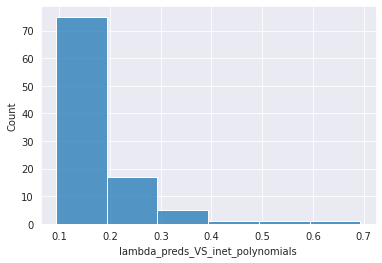

In [54]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

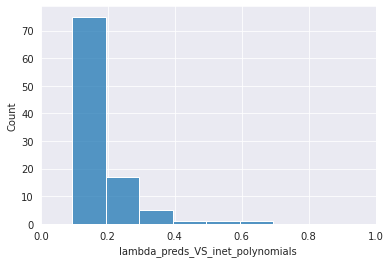

In [55]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


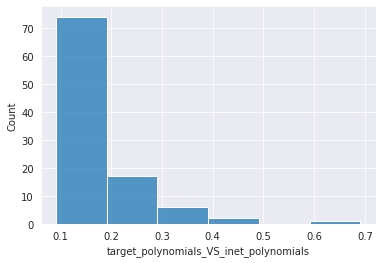

In [56]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

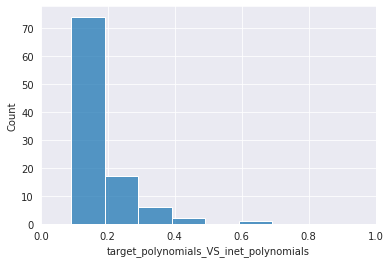

In [57]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


[(-30.0, 1.0)]

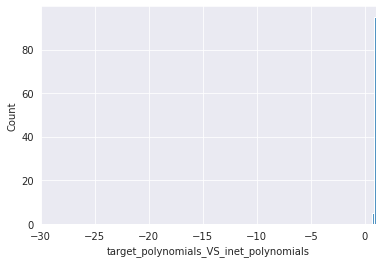

In [58]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

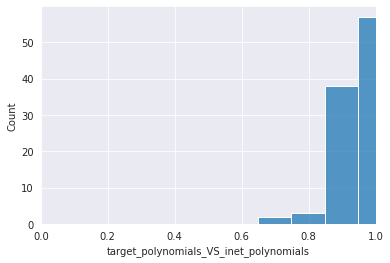

In [59]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

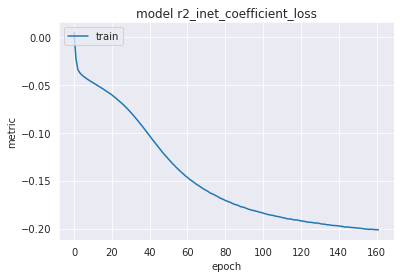

In [60]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


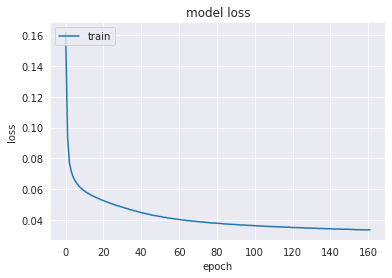

In [61]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [62]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [63]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [64]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [65]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


0.1756*a**2 - 0.1745*a*b + 0.688*a*c - 0.2228*a*d - 0.122*a*e - 0.6669*a*f - 0.1644*a*g - 0.2126*a*h - 0.6422*a*i - 0.0312*a + 0.5737*b**2 + 0.7417*b*c + 0.7616*b*d + 0.3943*b*e + 0.8305*b*f + 0.7803*b*g + 0.5179*b*h - 0.0952*b*i + 0.1074*b - 0.0423*c**2 + 0.8671*c*d - 0.0726*c*e + 0.8698*c*f + 0.0531*c*g - 0.4414*c*h + 0.0895*c*i + 1.1904*c - 0.4346*d**2 + 0.5304*d*e - 0.5776*d*f - 0.8689*d*g + 0.7806*d*h - 0.9347*d*i + 0.2641*d + 0.1851*e**2 + 0.5729*e*f - 0.4677*e*g + 0.2408*e*h + 0.3304*e*i - 0.6861*e + 0.0201*f**2 + 0.272*f*g - 0.3676*f*h - 0.6097*f*i + 0.002*f - 0.5425*g**2 + 0.8542*g*h - 0.7238*g*i - 1.0701*g + 0.1149*h**2 - 0.3153*h*i - 0.0947*h + 0.5965*i**2 - 0.5987*i - 1.088

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_target_polynomials


0.2301*a**2 - 0.1897*a*b + 0.7283*a*c - 0.2189*a*d - 0.1376*a*e - 0.708*a*f - 0.1805*a*g - 0.234*a*h - 0.6943*a*i - 0.0386*a + 0.7005*b**2 + 0.8451*b*c + 0.809*b*d + 0.4118*b*e + 0.9329*b*f + 0.8076*b*g + 0.5856*b*h - 0.1282*b*i - 0.1539*b + 0.0542*c**2 + 0.9142*c*d - 0.0707*c*e + 0.9578*c*f + 0.0576*c*g - 0.4388*c*h + 0.1182*c*i + 0.931*c - 0.5123*d**2 + 0.5729*d*e - 0.6323*d*f - 0.9872*d*g + 0.8317*d*h - 0.9965*d*i + 0.3901*d + 0.3263*e**2 + 0.6496*e*f - 0.4741*e*g + 0.3*e*h + 0.3728*e*i - 0.9558*e + 0.036*f**2 + 0.3053*f*g - 0.3977*f*h - 0.6228*f*i - 0.1066*f - 0.5758*g**2 + 0.8732*g*h - 0.7998*g*i - 0.9866*g + 0.1865*h**2 - 0.3987*h*i - 0.1631*h + 0.6919*i**2 - 0.5639*i - 0.9449

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


0.2301*a**2 - 0.1897*a*b + 0.7283*a*c - 0.2189*a*d - 0.1376*a*e - 0.708*a*f - 0.1805*a*g - 0.234*a*h - 0.6943*a*i - 0.0386*a + 0.7005*b**2 + 0.8451*b*c + 0.809*b*d + 0.4118*b*e + 0.9329*b*f + 0.8076*b*g + 0.5856*b*h - 0.1282*b*i - 0.1539*b + 0.0542*c**2 + 0.9142*c*d - 0.0707*c*e + 0.9578*c*f + 0.0576*c*g - 0.4388*c*h + 0.1182*c*i + 0.931*c - 0.5123*d**2 + 0.5729*d*e - 0.6323*d*f - 0.9872*d*g + 0.8317*d*h - 0.9965*d*i + 0.3901*d + 0.3263*e**2 + 0.6496*e*f - 0.4741*e*g + 0.3*e*h + 0.3728*e*i - 0.9558*e + 0.036*f**2 + 0.3053*f*g - 0.3977*f*h - 0.6228*f*i - 0.1066*f - 0.5758*g**2 + 0.8732*g*h - 0.7998*g*i - 0.9866*g + 0.1865*h**2 - 0.3987*h*i - 0.1631*h + 0.6919*i**2 - 0.5639*i - 0.9449

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


0.242799997329712*a**2 + 0.0987000018358231*a*b + 1.22839999198914*a*c - 0.193900004029274*a*d - 0.412000000476837*a*e - 0.540600001811981*a*f - 0.425399988889694*a*g - 0.55460000038147*a*h - 0.453799992799759*a*i - 0.0711999982595444*a + 0.308400005102158*b**2 + 0.575800001621246*b*c + 0.469199985265732*b*d + 0.339899986982346*b*e + 0.76230001449585*b*f + 0.678799986839294*b*g + 0.402200013399124*b*h + 0.0934000015258789*b*i + 0.57480001449585*b + 0.269499987363815*c**2 + 0.543699979782104*c*d - 0.0511000007390976*c*e + 0.790199995040894*c*f - 0.394499987363815*c*g - 0.0184000004082918*c*h + 0.0353999994695187*c*i + 0.907400012016296*c - 0.0654999986290932*d**2 + 0.299600005149841*d*e - 0.1283999979496*d*f - 0.596700012683868*d*g + 0.549199998378754*d*h - 0.488999992609024*d*i - 0.138600006699562*d - 0.097800001502037*e**2 + 0.411700010299683*e*f - 0.436100006103516*e*g + 0.156599998474121*e*h + 0.0623000003397465*e*i - 0.110600002110004*e - 0.0483000017702579*f**2 + 0.20890000462532*

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


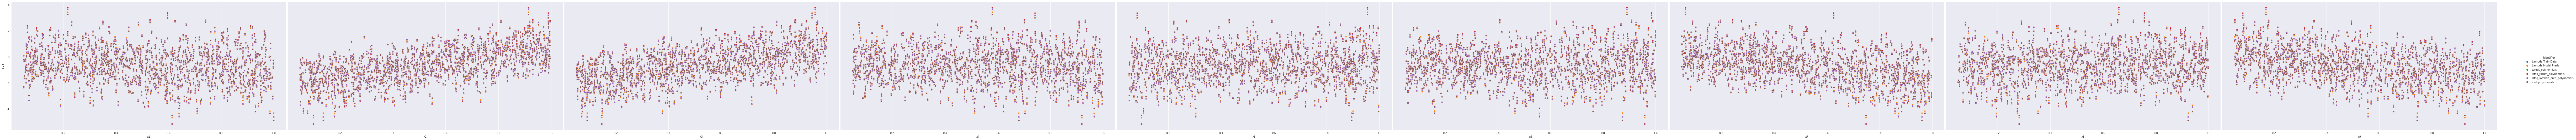

In [66]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

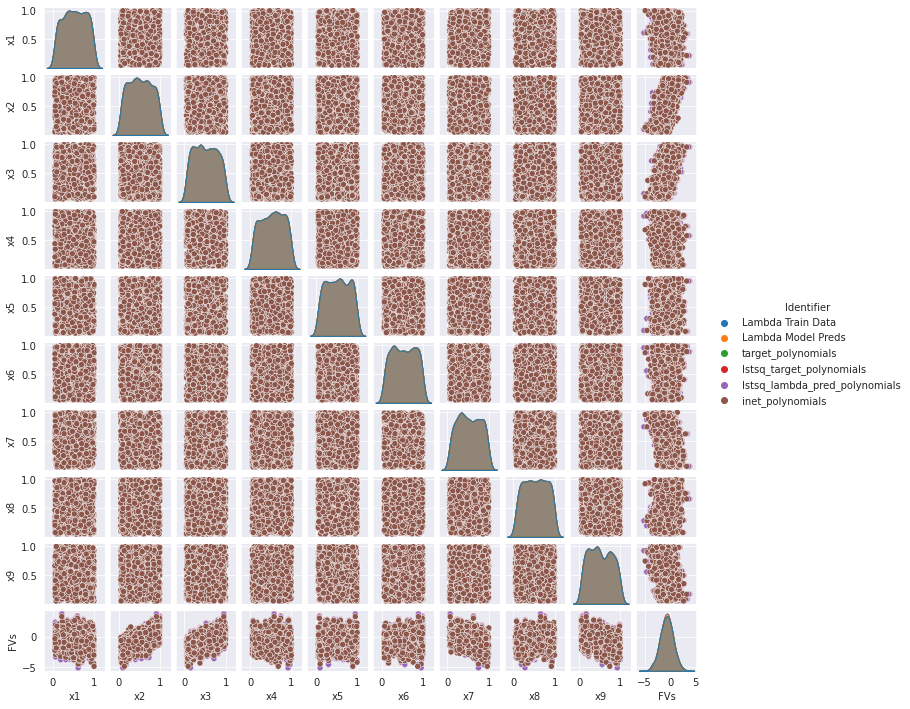

In [67]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

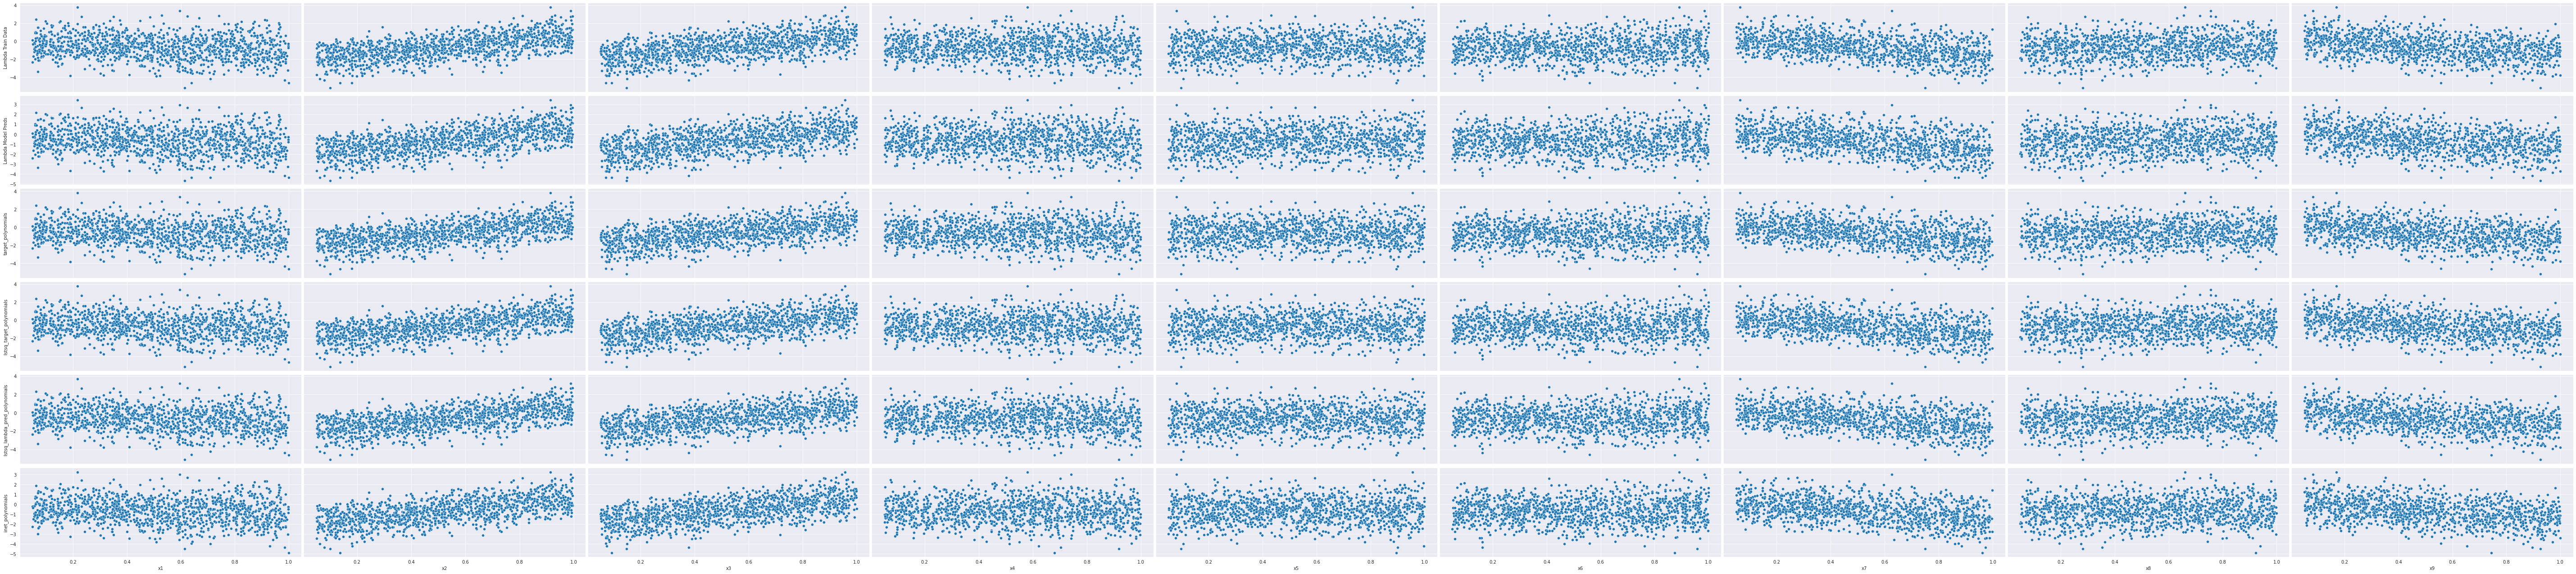

In [68]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [69]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [70]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [71]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.043


In [72]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 13.4548


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [73]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [74]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 1.4092


In [75]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [76]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


Current best: 0.635664701461792 
 Curr_res: 1.5393879413604736 
 Iteration 1, Step 21
Optimization terminated at 0.5248916149139404


array([ 0.12254932, -0.23129267, -0.37420854,  0.3213261 , -0.00083357,
       -0.3470592 , -0.09979569, -0.50700533, -0.5846916 ,  0.06028908,
        0.20725837, -0.5375066 ,  0.30519825, -0.06240285, -0.27727804,
        0.1704337 , -0.07967258, -0.15722053, -0.22406825, -0.39622128,
       -0.5977403 , -0.48374945, -0.19307616, -0.11031966, -0.33393455,
        0.23058625, -0.41471553,  0.13155362,  0.21153104, -0.6124849 ,
       -0.34887347, -0.41662303, -0.01791227,  0.05376747,  0.24472749,
       -0.3873374 ,  0.05733331,  0.05044834, -0.30656135,  0.0885165 ,
       -0.17536663,  0.29092395,  0.14686853,  0.4108556 , -0.4210713 ,
       -0.4241811 , -0.35659695,  0.5639242 ,  0.2488742 , -0.39297855,
       -0.09746617, -0.41042578,  0.36832955,  0.4021538 , -0.10630316],
      dtype=float32)

# Evaluate Real Dataset


##  Auto MPG-Dataset

In [78]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

Cylinders  Displacement  Horsepower  Weight  Acceleration  Model Year  \
0      1.000         0.618       0.457   0.536         0.238       0.000   
1      1.000         0.729       0.647   0.590         0.208       0.000   
2      1.000         0.646       0.565   0.517         0.179       0.000   
3      1.000         0.610       0.565   0.516         0.238       0.000   
4      1.000         0.605       0.511   0.521         0.149       0.000   

   Europe  Japan   USA  
0   0.000  0.000 1.000  
1   0.000  0.000 1.000  
2   0.000  0.000 1.000  
3   0.000  0.000 1.000  
4   0.000  0.000 1.000

In [79]:
#%load_ext autoreload

In [80]:
np.isinf(features_autoMPG_model.values).any()

False

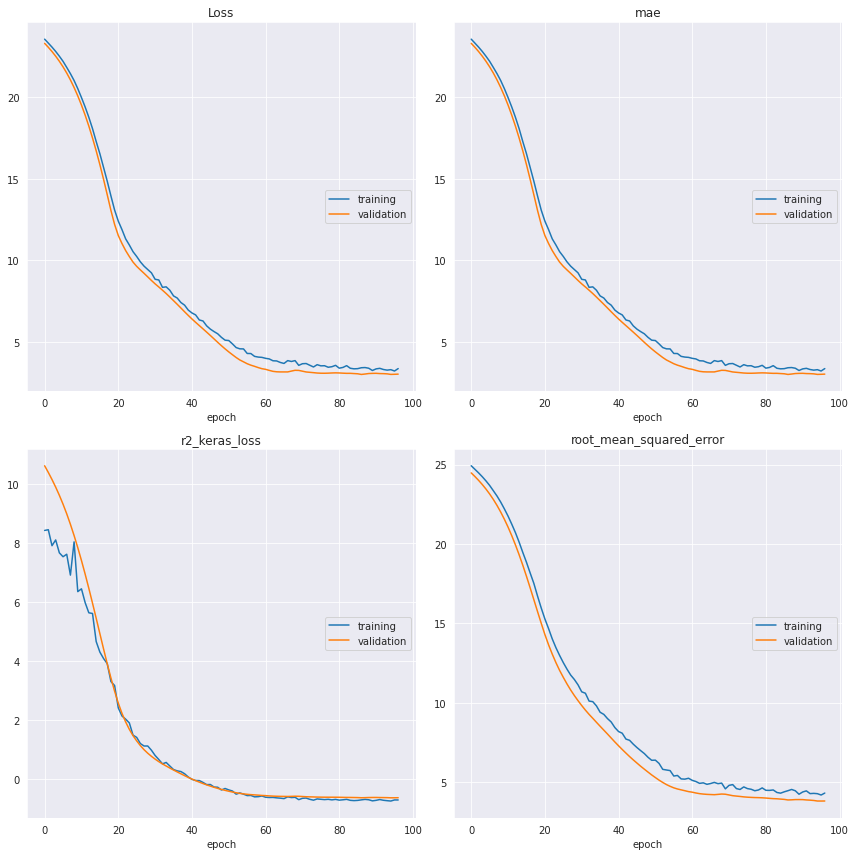

Loss
	training         	 (min:    3.218, max:   23.561, cur:    3.368)
	validation       	 (min:    3.008, max:   23.306, cur:    3.027)
mae
	training         	 (min:    3.218, max:   23.561, cur:    3.368)
	validation       	 (min:    3.008, max:   23.306, cur:    3.027)
r2_keras_loss
	training         	 (min:   -0.739, max:    8.463, cur:   -0.702)
	validation       	 (min:   -0.629, max:   10.632, cur:   -0.626)
root_mean_squared_error
	training         	 (min:    4.182, max:   24.931, cur:    4.306)
	validation       	 (min:    3.803, max:   24.481, cur:    3.805)


In [81]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [83]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 1, 250)#tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [84]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [86]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LSTSQt Poly:


25.2334641555134*a**2 + 34.0356880775596*a*b + 18.0968001892182*a*c + 25.6578929838337*a*d + 11.7939267868026*a*e + 28.4180648691697*a*f + 22.3200774211111*a*g + 31.2080477584371*a*h + 15.2870854213859*a*i + 10.409017569042*a + 14.8639299723888*b**2 + 26.3602105017753*b*c + 34.2420904637585*b*d + 27.2340626095321*b*e + 13.5112085491683*b*f + 10.2848685220333*b*g + 14.4937715575262*b*h + 20.4294533786656*b*i + 15.9298052135591*b + 35.6504566012838*c**2 + 12.0298279287769*c*d + 35.1387576286473*c*e + 21.0037080784651*c*f + 23.052920494809*c*g + 15.3850118722553*c*h + 26.3634290814236*c*i + 30.0685463420346*c + 15.592607239952*d**2 + 26.753158039535*d*e + 26.008746718858*d*f + 27.5272225408919*d*g + 11.1004291997822*d*h + 34.6351300337335*d*i + 40.0970754814425*d + 15.5482128837524*e**2 + 31.5779047304701*e*f + 24.7252919502217*e*g + 34.5786234247621*e*h + 19.4185381303301*e*i + 30.2720147884516*e + 27.9941569485425*f**2 + 29.0107171904432*f*g + 19.4023885706523*f*h + 27.4636786563587*f*i

MAE Model:  0.16548031003571373
MAE Data:  3.255920117251367
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [87]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, normalized=False, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation Net Poly:


3.04431438446045*a**2 - 0.666646957397461*a*b - 1.95870113372803*a*c - 0.468309283256531*a*d - 1.85143887996674*a*e - 0.887565732002258*a*f - 0.130955278873444*a*g + 0.574231922626495*a*h + 0.827716588973999*a*i - 2.10557532310486*a + 1.40765690803528*b**2 - 0.00528201553970575*b*c - 0.687098741531372*b*d - 1.56532120704651*b*e + 1.25186991691589*b*f - 0.458095699548721*b*g - 0.193678453564644*b*h - 0.0634856373071671*b*i + 0.0170515328645706*b + 2.09115886688232*c**2 - 0.289864599704742*c*d - 0.86871737241745*c*e + 0.0594853311777115*c*f + 0.953812658786774*c*g + 0.945802092552185*c*h + 0.0234602615237236*c*i - 0.247609853744507*c + 2.4430992603302*d**2 + 1.27080702781677*d*e + 1.7745224237442*d*f - 0.830051004886627*d*g + 0.976043164730072*d*h + 0.674410223960876*d*i - 1.21311509609222*d + 2.9074649810791*e**2 - 0.136984467506409*e*f + 1.19020235538483*e*g - 1.44882655143738*e*h - 1.39910840988159*e*i - 1.15003645420074*e + 1.15161955356598*f**2 - 0.15649089217186*f*g - 1.69133079051

MAE Model:  9.736255564516847
MAE Data:  8.833554360869158
Computation Time: 0:00:00
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [88]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


Current best: 0.5725048780441284 
 Curr_res: 0.5735082626342773 
 Iteration 2, Step 499
Optimization terminated at 0.5667936205863953
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Per Network Poly:


-0.401564359664917*a**2 - 1.747398853302*a*b - 1.75268113613129*a*c - 2.35011506080627*a*d - 0.632284164428711*a*e - 0.795030236244202*a*f - 0.393719613552094*a*g + 0.140379622578621*a*h - 1.58772647380829*a*i + 3.95993614196777*a - 1.05826961994171*b**2 - 1.54583203792572*b*c - 1.84980309009552*b*d - 0.733604550361633*b*e - 1.01728105545044*b*f - 0.815563499927521*b*g - 0.875715255737305*b*h - 1.28660786151886*b*i + 3.66064453125*b - 0.744259119033813*c**2 - 1.7359117269516*c*d - 0.60320633649826*c*e - 0.729791879653931*c*f - 0.690835177898407*c*g - 0.548020958900452*c*h - 1.6642678976059*c*i + 4.51190614700317*c - 0.541940093040466*d**2 - 1.00056338310242*d*e - 0.612938106060028*d*f - 0.809862375259399*d*g - 0.703649520874023*d*h - 1.62333106994629*d*i + 3.36482119560242*d + 2.74409580230713*e**2 + 1.6846342086792*e*f + 1.7714616060257*e*g + 1.9621285200119*e*h + 0.962517738342285*e*i + 5.75417852401733*e + 2.95962524414063*f**2 + 2.08470392227173*f*g + 2.19931817054749*f*h + 0.67490

MAE Model:  1.745171229872046
MAE Data:  3.4380749709252765
Computation Time: 0:02:08
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [90]:
#%load_ext autoreload

In [91]:
%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    27.26          757.815      127           17.279           19.336      2.83m
   1    16.33          28.4918       11          7.70091          6.75048      2.17m
   2    29.29           28.284        5          6.36069          6.55403      2.53m
   3    45.97          24.4163       47          4.25631          3.57764      2.90m
   4    34.46          25.6137       43          2.88252          2.90624      2.46m
   5    32.60          24.9344       51          2.51632          2.68834      2.37m
   6    35.62          23.6869       39           2.3591          2.47117      2.15m
   7    39.49          19.5359       39          2.30471          2.16195      2.03m
   8    42.38          16.8078       35          1.96552          2.11239  

((X3 + X8)*(X5 + 0.663) + (X3 + X8)*(X7 + 0.624)*(9.63781636002419*X4 + 8.63781636002419*X5 + 9.63781636002419*X6 + 14.9253731343284*X7 + 8.63781636002419*X8) + (X5 + 0.663)*(X7 + 0.624))/((X3 + X8)*(X7 + 0.624))

MAE Model:  13.628779279961568
MAE Data:  13.620343727925448
Computation Time: 0:03:25
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [103]:
#%autoreload 2
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling_original(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [105]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

---- Tuning the basis functions ----


  0%|          | 0/9 [00:00<?, ?it/s]

----  Optimizing the metamodel  ----


  0%|          | 0/500 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Metamodel Function:


1/(1.10359364352633e+916*exp(-0.255135513836599*X0**2*X1**2 - 0.168124525842695*X0**2*X2**2 - 0.277582093877973*X0**2*X3**2 + 0.0264332363599323*X0**2*X4**2 - 0.0669250550542981*X0**2*X5**2 - 0.061434214535044*X0**2*X6**2 + 0.0612000836061271*X0**2*X7**2 - 0.0529336159402214*X0**2*X8**2 - 76.0038490145132*X0**2 + 2.46224637322794*X0*X1 + 1.50191323601003*X0*X2 + 2.47535059169168*X0*X3 - 0.26599273557516*X0*X4 + 0.682867416411536*X0*X5 + 0.725976024546373*X0*X6 - 0.640646343275663*X0*X7 + 0.503233871258246*X0*X8 + 64.1694094622448*X0 - 0.290512291839904*X1**2*X2**2 - 0.219286862967622*X1**2*X3**2 + 0.066389145260724*X1**2*X4**2 - 0.0136456020957105*X1**2*X5**2 - 0.0330763415436724*X1**2*X6**2 - 0.00631363429078283*X1**2*X7**2 - 0.0722338336816805*X1**2*X8**2 - 24.6328528927776*X1**2 + 2.68423656600491*X1*X2 + 2.05206279830223*X1*X3 - 0.700411870427345*X1*X4 + 0.14224750486389*X1*X5 + 0.389693900291299*X1*X6 + 0.0702622933975371*X1*X7 + 0.659962508614608*X1*X8 + 51.6923674496315*X1 - 0.2

MAE Model:  23.229867730821883
MAE Data:  22.70714285714286
Computation Time: 0:01:04
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [110]:
%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

Expression: 1.0*x**1.0*exp(-1.0*x)
Loss: 906.7258578278872
Expression: 1.0*x**1.00000001490116*exp(-1.0*x)
Loss: 906.725857974449
Expression: 1.00000001490116*x**1.0*exp(-1.00000001490116*x)
Loss: 906.7258577328867
Expression: 1.0*x**1.0*exp(-1.0*x)
Loss: 906.7258578278872
Expression: 1.06903838511741*x**0.152473548393619*exp(-1.54936227921792*x)
Loss: 897.9702573269888
Expression: 1.06903838511741*x**0.152473548393619*exp(-1.54936227921792*x)
Loss: 897.9702573269888
Expression: 1.06903839209222*x**0.15247356329478*exp(-1.54936227921792*x)
Loss: 897.9702575355193
Expression: 1.06903838668508*x**0.152473548393619*exp(-1.54936229411908*x)
Loss: 897.970257463136
Expression: 0.0138897345509794*x**(-3.23763225803191)*exp(-3.74681139608961*x)
Loss: 894.8746237445662
Expression: 0.0138897345509794*x**(-3.23763225803191)*exp(-3.74681139608961*x)
Loss: 894.8746237445662
Expression: 0.0138897348243713*x**(-3.23763224313075)*exp(-3.74681139608961*x)
Loss: 894.8746259835979
Expression: 0.013889734

ValueError: in user code:

    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_202 is incompatible with the layer: expected axis -1 of input shape to have value 9 but received input with shape (None, 1)


In [111]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function:')
    #display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation Net Poly:


3.04431438446045*a**2 - 0.666646957397461*a*b - 1.95870113372803*a*c - 0.468309283256531*a*d - 1.85143887996674*a*e - 0.887565732002258*a*f - 0.130955278873444*a*g + 0.574231922626495*a*h + 0.827716588973999*a*i - 2.10557532310486*a + 1.40765690803528*b**2 - 0.00528201553970575*b*c - 0.687098741531372*b*d - 1.56532120704651*b*e + 1.25186991691589*b*f - 0.458095699548721*b*g - 0.193678453564644*b*h - 0.0634856373071671*b*i + 0.0170515328645706*b + 2.09115886688232*c**2 - 0.289864599704742*c*d - 0.86871737241745*c*e + 0.0594853311777115*c*f + 0.953812658786774*c*g + 0.945802092552185*c*h + 0.0234602615237236*c*i - 0.247609853744507*c + 2.4430992603302*d**2 + 1.27080702781677*d*e + 1.7745224237442*d*f - 0.830051004886627*d*g + 0.976043164730072*d*h + 0.674410223960876*d*i - 1.21311509609222*d + 2.9074649810791*e**2 - 0.136984467506409*e*f + 1.19020235538483*e*g - 1.44882655143738*e*h - 1.39910840988159*e*i - 1.15003645420074*e + 1.15161955356598*f**2 - 0.15649089217186*f*g - 1.69133079051

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Per Network Poly:


-0.401564359664917*a**2 - 1.747398853302*a*b - 1.75268113613129*a*c - 2.35011506080627*a*d - 0.632284164428711*a*e - 0.795030236244202*a*f - 0.393719613552094*a*g + 0.140379622578621*a*h - 1.58772647380829*a*i + 3.95993614196777*a - 1.05826961994171*b**2 - 1.54583203792572*b*c - 1.84980309009552*b*d - 0.733604550361633*b*e - 1.01728105545044*b*f - 0.815563499927521*b*g - 0.875715255737305*b*h - 1.28660786151886*b*i + 3.66064453125*b - 0.744259119033813*c**2 - 1.7359117269516*c*d - 0.60320633649826*c*e - 0.729791879653931*c*f - 0.690835177898407*c*g - 0.548020958900452*c*h - 1.6642678976059*c*i + 4.51190614700317*c - 0.541940093040466*d**2 - 1.00056338310242*d*e - 0.612938106060028*d*f - 0.809862375259399*d*g - 0.703649520874023*d*h - 1.62333106994629*d*i + 3.36482119560242*d + 2.74409580230713*e**2 + 1.6846342086792*e*f + 1.7714616060257*e*g + 1.9621285200119*e*h + 0.962517738342285*e*i + 5.75417852401733*e + 2.95962524414063*f**2 + 2.08470392227173*f*g + 2.19931817054749*f*h + 0.67490

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LSTSQ Poly:


-0.0100505167892266*a**2 + 0.0502135029625142*a*b + 0.0343047745816261*a*c + 0.0461889496102375*a*d - 0.0589479665707366*a*e - 0.0698075192923296*a*f - 0.00545599830028998*a*g - 0.0245755078171652*a*h - 0.0324540893546194*a*i - 1.63511587148845*a + 0.0414559888887234*b**2 + 0.013303660869558*b*c + 0.0842788794909586*b*d - 0.0750563532460149*b*e - 0.0675969094059232*b*f - 0.0508516245517586*b*g - 0.040959778314988*b*h - 0.0270981911129327*b*i - 2.93012527789599*b + 0.0348126375600093*c**2 + 0.0550866841099644*c*d - 0.0478499506378895*c*e - 0.0832835776480789*c*f - 0.0417608894952581*c*g - 0.0191740262277458*c*h - 0.00496029106677898*c*i - 1.53527772552002*c + 0.0704666018859592*d**2 - 0.0861204252708534*d*e - 0.100124449877808*d*f - 0.0649546354019666*d*g - 0.0515375829062279*d*h - 0.0284459312120102*d*i - 3.25421556863164*d + 0.0477560415793055*e**2 + 0.0834307621117665*e*f + 0.0795251822408135*e*g + 0.0412924911877943*e*h + 0.0322031472086434*e*i + 10.1675341466644*e + 0.0665996437663

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Symbolic Regression Function:


((X3 + X8)*(X5 + 0.663) + (X3 + X8)*(X7 + 0.624)*(9.63781636002419*X4 + 8.63781636002419*X5 + 9.63781636002419*X6 + 14.9253731343284*X7 + 8.63781636002419*X8) + (X5 + 0.663)*(X7 + 0.624))/((X3 + X8)*(X7 + 0.624))

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


ValueError: x and y must be the same size

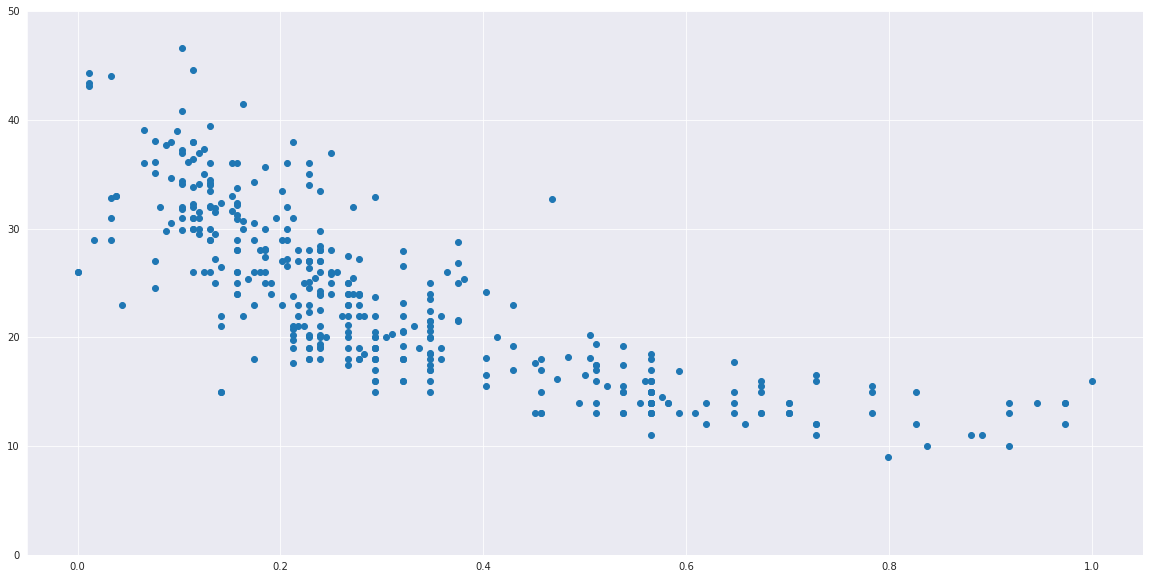

In [112]:
if interpretation_possible_autoMPG:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])


In [ ]:
current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 

In [ ]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

In [ ]:
model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

In [ ]:
model.get_weights()

In [ ]:
model.predict([1, 10])

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 

In [ ]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

In [ ]:
model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

In [ ]:
model.get_weights()

In [ ]:
model.predict([1, 10])

In [ ]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

In [ ]:
model.fit(sample_data_X,
         sample_data_y,
         epochs=500,
         verbose=0)

In [ ]:
model_2 = keras.models.clone_model(model)

model_2.summary()

In [ ]:
model.get_weights()

In [ ]:
model.predict([1, 10])

In [ ]:
model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]

In [ ]:
model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

In [ ]:
#model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/1000
#model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

In [ ]:
model_2.set_weights(model_2_normalized_weights)

In [ ]:
model_2.get_weights()

In [ ]:
model_2.predict([1, 10])

In [ ]:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    if length_plt >= 2:
        fig, ax = plt.subplots(length_plt//2, 2, figsize=(30,20))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(20,10))

    for index, metric in enumerate(plot_metric_list):
        
        plot_scores_dict = {}
        for key in evaluation_key_list:
            try:
                scores_list[-1][metric].loc[key]
                plot_scores_dict[key] = []
            except:
                #print(key + 'not in scores_list')
                continue
            
        
        for scores in scores_list:
            for key in evaluation_key_list:
                try:
                    plot_scores_dict[key].append(scores[metric].loc[key])
                except:
                    #print(key + 'not in scores_list')
                    continue
                                        
            
        plot_df = pd.DataFrame(data=np.vstack(plot_scores_dict.values()).T, 
                               index=x_axis_steps,
                               columns=plot_scores_dict.keys())

        if length_plt >= 2:
            ax[index//2, index%2].set_title(metric)
            sns.set(font_scale = 1.25)
            p = sns.lineplot(data=plot_df, ax=ax[index//2, index%2])
        else:
            ax.set_title(metric)
            sns.set(font_scale = 1.25)
            p = sns.lineplot(data=plot_df, ax=ax)

        if ylim != None:
            p.set(ylim=ylim)

        p.set_yticklabels(np.round(p.get_yticks(), 2), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)     
        
        #p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        p.legend(loc='upper center', bbox_to_anchor=(0.47, -0.1),
          fancybox=False, shadow=False, ncol=2, fontsize=12)   
        
    plt.subplots_adjust(wspace=0.1, hspace=0.75)

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()